In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sps
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

from os.path import join
from pathlib import Path
cur_dir = Path(os.getcwd())
sys.path.append(str(cur_dir.parent.absolute()))

from GLOBE.builder import GLOBE
from GLOBE.config import Config
from GLOBE.trainval import get_args
from GLOBE.evaluation import scib_process
from GLOBE.kbet import calculate_kbet

from GLOBE.prepare_dataset import prepare_dataset, prepare_mnn
from GLOBE.preprocessing import preprocess_data, embPipe, hvgPipe


configs = Config()


In [2]:

class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

args_dict = {"exp_id": 'Simulation_0523', 
            "mode": 'unsupervised', 
            "dname": "Simulation/simul1_dropout_005_b1_500_b2_900",  # ignore this
             
            # pp params
            "select_hvg": False,
            "scale": False, 
             
            # network params 
            "block_level": 1,
            "lat_dim": 128,
            "proj_dim":64,
            "header":None,
            "init": 'uniform',
             
            # training params
            "add_noise": False,    # if add noise for positive
            "loss_type": 'GLOBE',  # GLOBE or InfoNCE
            "temp": 0.1,
            "load_ckpt": False,
            "ckpt_idx": 2,
            "sup_eps": 100,
            "sup_lr": 1e-4,
            'unsup_eps': 30,
            "unsup_lr": 1e-5,
            "weight_decay":1e-4,
            "batch_size": 256,
            "plot_loss": True,
            "save_freq": 10,
            "gpu": '0',
            "num_workers": 6}

args = Struct(**args_dict)
args.lr = args.sup_lr if args.mode=='supervised' else args.unsup_lr
args.eps = args.sup_eps if args.mode=='supervised' else args.unsup_eps
args.mode = args.mode + '-' + args.loss_type  # to be optimized


In [3]:
def write_to_csv(mat, genesname, cellsname, filename, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    if isinstance(mat, np.ndarray):
        df = pd.DataFrame(mat, columns=genesname, index=cellsname)
    else:
        df = pd.DataFrame(mat.toarray(), columns=genesname, index=cellsname)        
    
    df.to_csv(os.path.join(save_dir,filename))

### GLOBE for Simulations

reading Anchors from  /home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Script/sapling/GLOBE/data/Simulation/simul1_dropout_005_b1_500_b2_900/all_seuratAnchors.csv
building dataset
building model


100%|██████████| 6/6 [00:00<00:00,  9.36batch/s, loss=3.06]


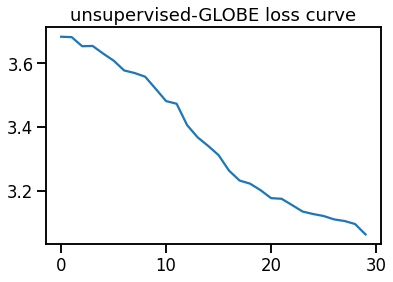

=> loaded unsupervised-GLOBE checkpoint 30


... storing 'Batch' as categorical
... storing 'Group' as categorical


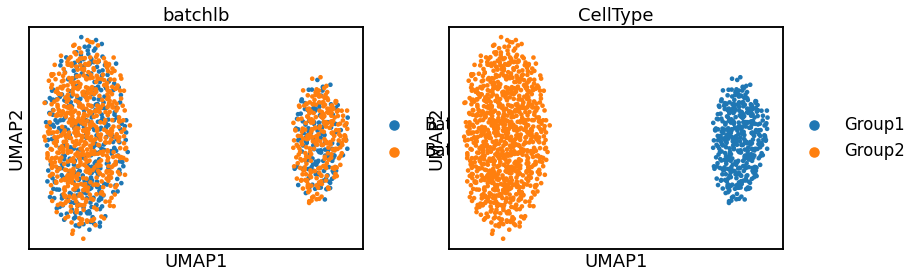

=> gene integrated


... storing 'Batch' as categorical
... storing 'Group' as categorical


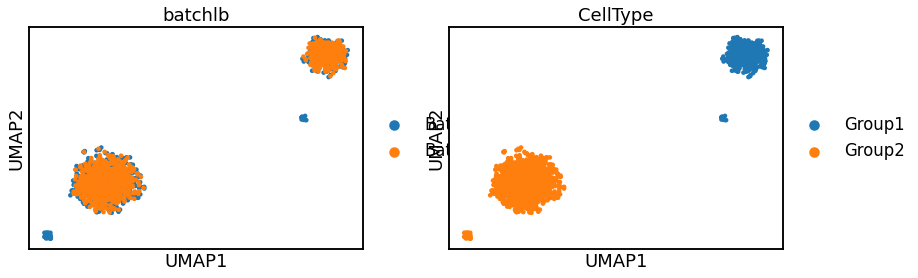

reading Anchors from  /home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Script/sapling/GLOBE/data/Simulation/simul2_dropout_025_b1_500_b2_900/all_seuratAnchors.csv


  0%|          | 0/6 [00:00<?, ?batch/s]

building dataset
building model


100%|██████████| 6/6 [00:00<00:00,  8.08batch/s, loss=3.1]


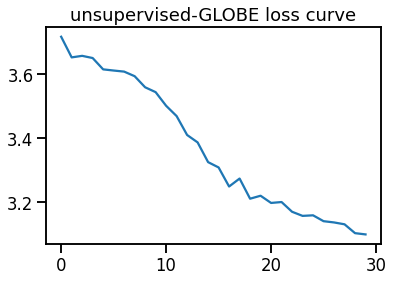

=> loaded unsupervised-GLOBE checkpoint 30


... storing 'Batch' as categorical
... storing 'Group' as categorical


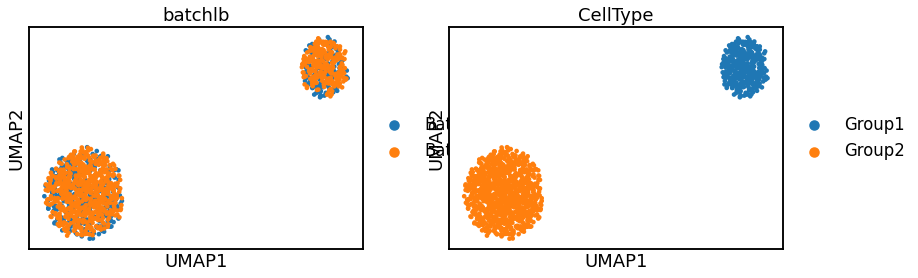

=> gene integrated


... storing 'Batch' as categorical
... storing 'Group' as categorical


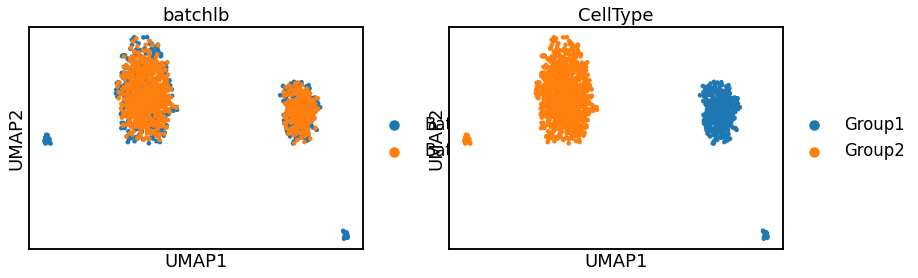

reading Anchors from  /home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Script/sapling/GLOBE/data/Simulation/simul3_dropout_005_b1_500_b2_450/all_seuratAnchors.csv


  0%|          | 0/4 [00:00<?, ?batch/s]

building dataset
building model


100%|██████████| 4/4 [00:00<00:00,  5.75batch/s, loss=3.56]


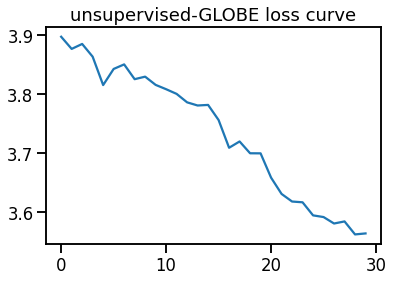

=> loaded unsupervised-GLOBE checkpoint 30


... storing 'Batch' as categorical
... storing 'Group' as categorical


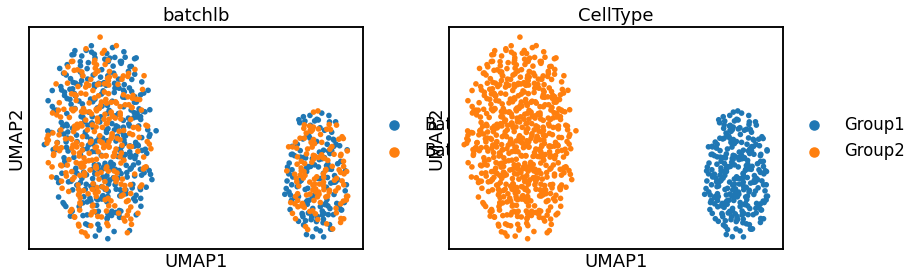

=> gene integrated


... storing 'Batch' as categorical
... storing 'Group' as categorical


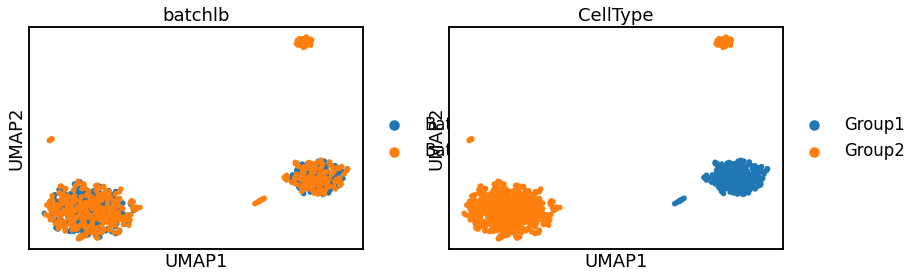

reading Anchors from  /home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Script/sapling/GLOBE/data/Simulation/simul4_dropout_025_b1_500_b2_450/all_seuratAnchors.csv


  0%|          | 0/4 [00:00<?, ?batch/s]

building dataset
building model


100%|██████████| 4/4 [00:01<00:00,  2.85batch/s, loss=3.58]


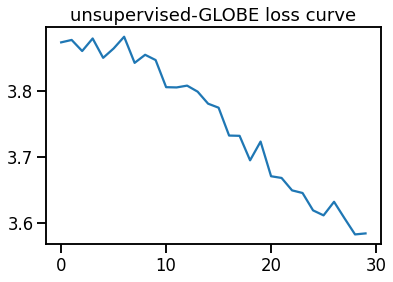

=> loaded unsupervised-GLOBE checkpoint 30


... storing 'Batch' as categorical
... storing 'Group' as categorical


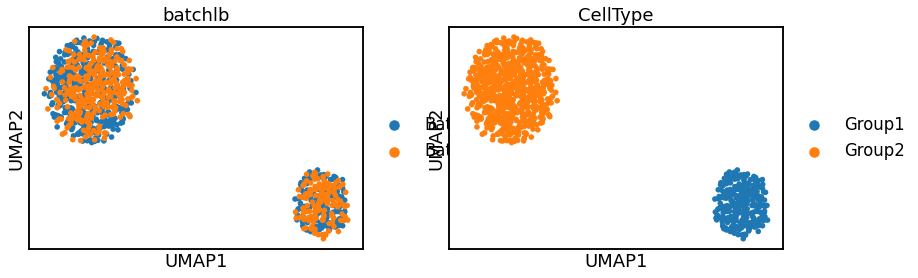

=> gene integrated


... storing 'Batch' as categorical
... storing 'Group' as categorical


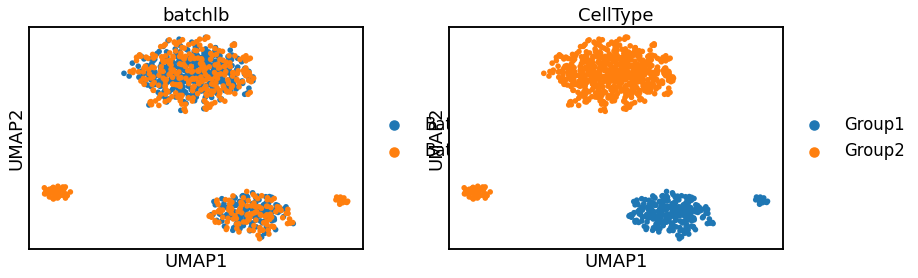

reading Anchors from  /home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Script/sapling/GLOBE/data/Simulation/simul5_dropout_005_b1_80_b2_400/all_seuratAnchors.csv
building dataset
building model


100%|██████████| 2/2 [00:00<00:00,  2.83batch/s, loss=3.54]


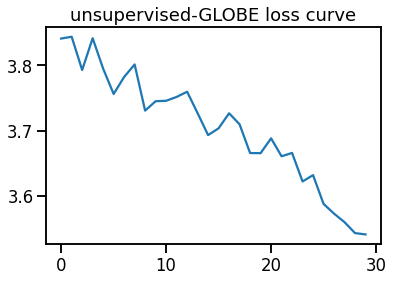

=> loaded unsupervised-GLOBE checkpoint 30


... storing 'Batch' as categorical
... storing 'Group' as categorical


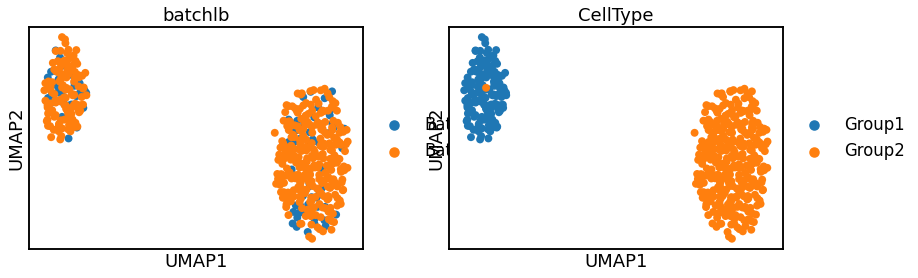

=> gene integrated


... storing 'Batch' as categorical
... storing 'Group' as categorical


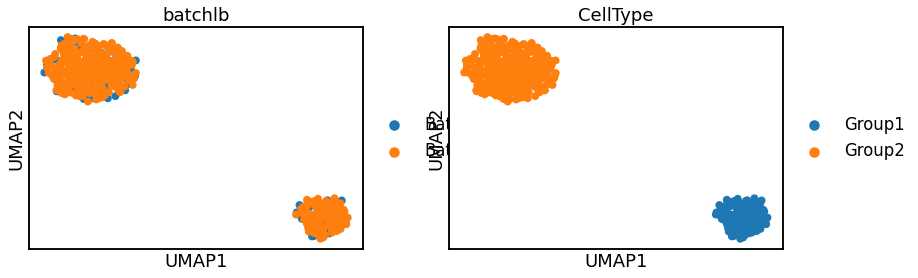

reading Anchors from  /home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Script/sapling/GLOBE/data/Simulation/simul6_dropout_025_b1_80_b2_400/all_seuratAnchors.csv
building dataset
building model


100%|██████████| 2/2 [00:00<00:00,  3.10batch/s, loss=3.54]


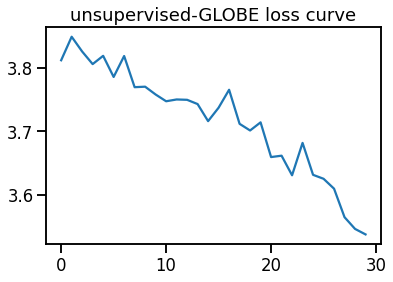

=> loaded unsupervised-GLOBE checkpoint 30


... storing 'Batch' as categorical
... storing 'Group' as categorical


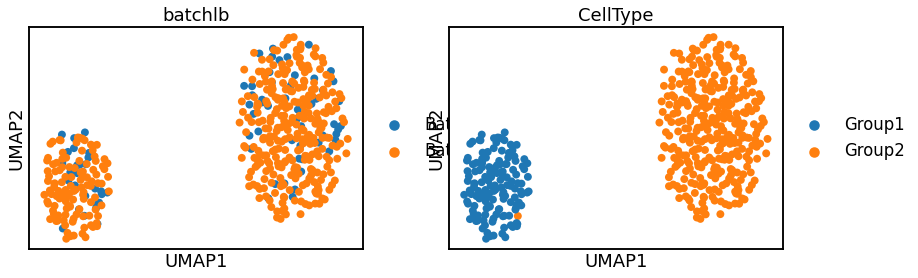

=> gene integrated


... storing 'Batch' as categorical
... storing 'Group' as categorical


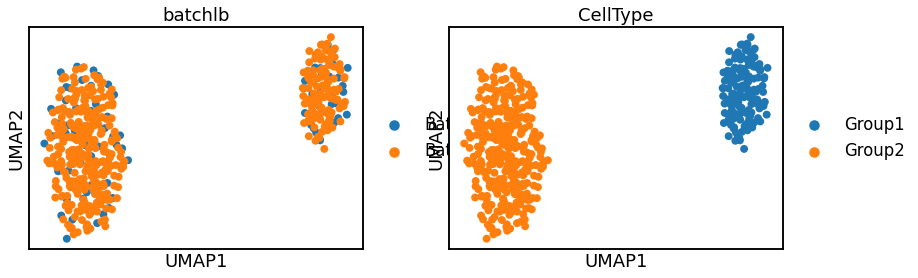

In [4]:
fds = ['simul1_dropout_005_b1_500_b2_900', 'simul2_dropout_025_b1_500_b2_900', 'simul3_dropout_005_b1_500_b2_450','simul4_dropout_025_b1_500_b2_450','simul5_dropout_005_b1_80_b2_400','simul6_dropout_025_b1_80_b2_400']

gs = 'all' 

for fd in fds:
    # prepare dataset
    dname = f'Simulation/{fd}'
    sps_x, genes, cells, metadata = prepare_dataset(join(configs.data_root, dname))
    anchor_data = prepare_mnn(join(configs.data_root, dname), f'{gs}_seuratAnchors.csv') if args.mode.startswith('unsupervised') else None

    # preprocessing
    sps_x, pp_genes, pp_cells, pp_metadata, pp_anchor_data = preprocess_data(sps_x, 
                                                                cnames=cells, 
                                                                gnames=genes, 
                                                                metadata=metadata, 
                                                                anchor_data=anchor_data,
                                                                select_hvg=args.select_hvg, 
                                                                scale=args.scale)


    # init model
    globe = GLOBE(
            mode=args.mode,          # supervised or unsupervised
            exp_id=join(args.exp_id, fd),
            gpu=args.gpu,
        )

    # create dataset and loader
    globe.build_dataset(
        sps_x=sps_x, 
        gnames=pp_genes, 
        cnames=pp_cells, 
        metadata=pp_metadata, 
        anchor_data=pp_anchor_data,
        add_noise=args.add_noise
    )

    # initializing network
    globe.build_model(
        lat_dim=args.lat_dim,
        proj_dim=args.proj_dim,
        header=args.header,
        block_level=args.block_level,
        init=args.init
    )
    
    globe.train(
        loss_type=args.loss_type,
        temp=args.temp,
        lr=args.lr,
        batch_size=args.batch_size,
        epochs=args.eps,
        plot_loss=args.plot_loss,
        save_freq=args.save_freq,
        weight_decay=args.weight_decay,
        num_workers=args.num_workers,
    )
    globe.load_ckpt(30) 

    lat_data, prj_data, metadata1 = globe.evaluate(batch_size=args.batch_size, num_workers=args.num_workers)
    prj_data = normalize(lat_data, axis=1)
    ad_e = embPipe(prj_data, metadata1)
    sc.pl.umap(ad_e, color=[configs.batch_key, configs.label_key])

    # Non-neural style decoder
    dec_rec, dec_metas = globe.integrate_gene(rec=prj_data, knn=10, alpha=0.1) # sigma=0.001, 
    ad_d = hvgPipe(dec_rec, dec_metas, npcs=50)
    sc.pl.umap(ad_d, color=[configs.batch_key, configs.label_key])
    
#     save_dir = join('/home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Output/dataset3', f'demo_GLOBE/{fd}/{gs}')

#     write_to_csv(dec_rec, 
#                  globe.dataset.gnames.values, 
#                  globe.dataset.cnames, 
#                  'output.csv', 
#                  save_dir)
    
#     break